In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn
# import scipy
# from scipy.optimize import minimize,least_squares
# import copy as copy
# import time as tpy
import glob
import os
# import pandas as pd
import pickle
from scipy.stats import wilcoxon as wilcoxon

# seaborn.set()

In [2]:
path = 'Data'

with open(path + '/continuous_full_data_block1.pickle', 'rb') as handle:
    refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)

with open(path + '/continuous_full_data_block2.pickle', 'rb') as handle:
    refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)

keys = ['METACPHS_S106', 'METACPHS_S107','METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112', 'METACPHS_S113', 'METACPHS_S114', 'METACPHS_S115', 'METACPHS_S116', 'METACPHS_S117', 'METACPHS_S118', 'METACPHS_S119']

In [4]:
subj = keys[0]
c = 3
# ref = refs_block1[subj][c, :]
# pos = poss_block1[subj][c, :]
# emg = emgs_block1[subj][c, :]
# Ds = Ws_block1[subj][c, :]
# vel_int = int_vel_block1[subj][c, :]
# vel_dec = dec_vels_block1[subj][c, :]

ref = refs_block2[subj][c, :]
pos = poss_block2[subj][c, :]
emg = emgs_block2[subj][c, :]
Ds = Ws_block2[subj][c, :]
vel_int = int_vel_block2[subj][c, :]
vel_dec = dec_vels_block2[subj][c, :]

print(f"ref.shape: {ref.shape}")
print(f"pos.shape: {pos.shape}")
print(f"emg.shape: {emg.shape}")
print(f"vel_int.shape: {vel_int.shape}")
print(f"vel_dec.shape: {vel_dec.shape}")
print(f"Ds.shape: {Ds.shape}")

ref.shape: (20770, 2)
pos.shape: (20770, 2)
emg.shape: (20770, 64)
vel_int.shape: (20770, 2)
vel_dec.shape: (20770, 2)
Ds.shape: (20770, 2, 64)


In [5]:
n_time, n_dim = pos.shape
print("(n_time, n_dim)")
print(pos.shape)

(n_time, n_dim)
(20770, 2)


In [6]:
ref.shape

(20770, 2)

In [7]:
def calculate_intended_vels(ref, pos, fs):
    '''
    ref = 1 x 2
    pos = 1 x 2
    fs = number
    '''
    
    # numbers from github code
    gain = 120
    ALMOST_ZERO_TOL = 0.01

    intended_vector = (ref - pos)/fs
    
    # in case this is close to zero
    if np.linalg.norm(intended_vector) <= ALMOST_ZERO_TOL:
        intended_norm = np.zeros((2,))
    else:
        intended_norm = intended_vector * gain #/ np.linalg.norm(intended_vector) * gain
        #intended_norm = np.reshape(intended_norm, (2, 1))
    
    return intended_norm
    

In [8]:
def reconstruct_trial(ref_tr, emg_tr, Ds_tr, time_x, fs = 60):
    time_x = time_x
    vel_est = np.zeros_like((ref_tr))
    pos_est = np.zeros_like((ref_tr))
    int_vel_est = np.zeros_like((ref_tr))


    hit_bound = 0
    vel_est[0] = Ds[0]@emg_tr[0] 
    pos_est[0] = [0, 0]
    for tt in range(1, time_x):
        vel_plus = Ds[tt-1]@emg_tr[tt] # at time tt
        p_plus = pos_est[tt-1, :] + (vel_est[tt-1, :]/fs)

        # x-coordinate
        if abs(p_plus[0]) > 36:
            p_plus[0] = pos_est[tt-1, 0]
            vel_plus[0] = 0
            hit_bound = hit_bound + 1 # update hit_bound counter

        if abs(p_plus[1]) > 24:
            p_plus[1] = pos_est[tt-1, 1]
            vel_plus[1] = 0
            hit_bound = hit_bound + 1 # update hit_bound counter

        if hit_bound > 200:
            p_plus[0] = 0
            vel_plus[0] = 0
            p_plus[1] = 0
            vel_plus[1] = 0
            hit_bound = 0


        # now update velocity and position
        vel_est[tt] = vel_plus
        pos_est[tt] = p_plus

        # calculate intended velocity
        int_vel_est[tt] = calculate_intended_vels(ref_tr[tt], p_plus, 60)

    return vel_est, pos_est, int_vel_est

In [9]:
def reconstruct_trial_fixed_decoder(ref_tr, emg_tr, Ds_fixed, time_x, fs = 60):
    time_x = time_x
    vel_est = np.zeros_like((ref_tr))
    pos_est = np.zeros_like((ref_tr))
    int_vel_est = np.zeros_like((ref_tr))


    hit_bound = 0
    vel_est[0] = Ds_fixed@emg_tr[0]  # D@s --> Kai's v_actual
    pos_est[0] = [0, 0]
    for tt in range(1, time_x):
        vel_plus = Ds_fixed@emg_tr[tt] # at time tt --> also Kai's v_actual...
        p_plus = pos_est[tt-1, :] + (vel_est[tt-1, :]/fs)

        # These are just correctives, such that vel_plus can get bounded
        # x-coordinate
        if abs(p_plus[0]) > 36:
            p_plus[0] = pos_est[tt-1, 0]
            vel_plus[0] = 0
            hit_bound = hit_bound + 1 # update hit_bound counter

        if abs(p_plus[1]) > 24:
            p_plus[1] = pos_est[tt-1, 1]
            vel_plus[1] = 0
            hit_bound = hit_bound + 1 # update hit_bound counter

        if hit_bound > 200:
            p_plus[0] = 0
            vel_plus[0] = 0
            p_plus[1] = 0
            vel_plus[1] = 0
            hit_bound = 0
        # now update velocity and position
        vel_est[tt] = vel_plus
        pos_est[tt] = p_plus
        # calculate intended velocity
        int_vel_est[tt] = calculate_intended_vels(ref_tr[tt], p_plus, 60)

    return vel_est, pos_est, int_vel_est

In [10]:
# time_x = n_time
# vel_est = np.zeros_like((ref))
# pos_est = np.zeros_like((ref))
# int_vel_est = np.zeros_like((ref))
# fs = 60

# hit_bound = 0
# vel_est[0] = Ds[0]@emg[0] 
# pos_est[0] = [0, 0]
# for tt in range(1, time_x):
#     vel_plus = Ds[tt-1]@emg[tt] # at time tt
#     p_plus = pos_est[tt-1, :] + (vel_est[tt-1, :]/fs)

#     # x-coordinate
#     if abs(p_plus[0]) > 36:
#         p_plus[0] = pos_est[tt-1, 0]
#         vel_plus[0] = 0
#         hit_bound = hit_bound + 1 # update hit_bound counter
    
#     if abs(p_plus[1]) > 24:
#         p_plus[1] = pos_est[tt-1, 1]
#         vel_plus[1] = 0
#         hit_bound = hit_bound + 1 # update hit_bound counter
        
#     if hit_bound > 200:
#         p_plus[0] = 0
#         vel_plus[0] = 0
#         p_plus[1] = 0
#         vel_plus[1] = 0
#         hit_bound = 0
    
    
#     # now update velocity and position
#     vel_est[tt] = vel_plus
#     pos_est[tt] = p_plus
    
#     # calculate intended velocity
#     int_vel_est[tt] = calculate_intended_vels(ref[tt], p_plus, 60)


In [11]:
time_x = n_time
print(time_x)
(vel_est, pos_est, int_vel_est) = reconstruct_trial(ref, emg, Ds, time_x, fs = 60)

20770


In [12]:
# true, true means that the error in estimation is 0

# position estimation
print(np.allclose(pos_est[:time_x, 0] - pos[:time_x, 0], 0))
print(np.allclose(pos_est[:time_x, 1] - pos[:time_x, 1], 0))

# intended velocity estimation
print(np.allclose(int_vel_est[:time_x, 0] - vel_int[:time_x, 0], 0))
print(np.allclose(int_vel_est[:time_x, 1] - vel_int[:time_x, 1], 0))


True
True
True
True


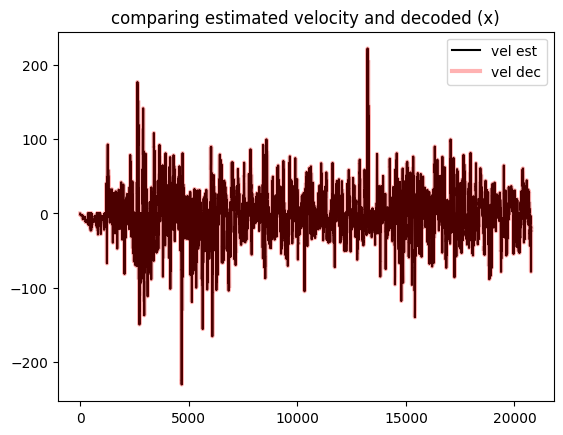

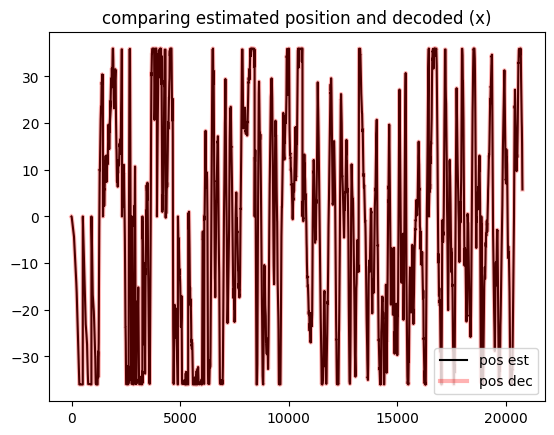

True

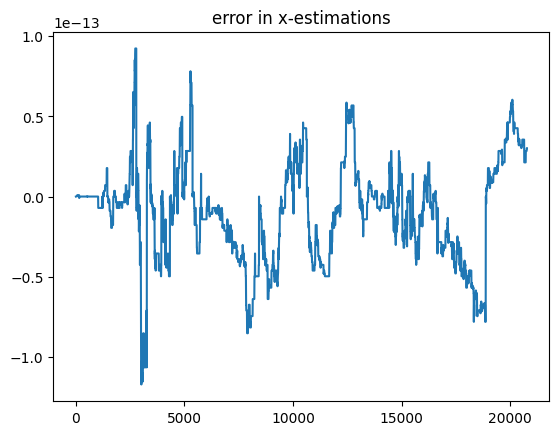

In [13]:
red_alpha = 0.3

plt.plot(vel_est[:time_x, 0], '-', label = "vel est", color = 'black')
plt.plot(vel_dec[:time_x, 0], lw = 3, label = "vel dec", alpha = red_alpha, color = 'red')
plt.legend()
plt.title("comparing estimated velocity and decoded (x)")
plt.show()

plt.plot(pos_est[:time_x, 0], '-', label = "pos est", color = 'black')
plt.plot(pos[:time_x, 0], lw = 3, label = "pos dec", alpha = red_alpha, color = 'red')
plt.legend()
plt.title("comparing estimated position and decoded (x)")
plt.show()

plt.plot(pos_est[:time_x, 0] - pos[:time_x, 0])
plt.title("error in x-estimations")

np.allclose(pos_est[:time_x, 0] - pos[:time_x, 0], 0)

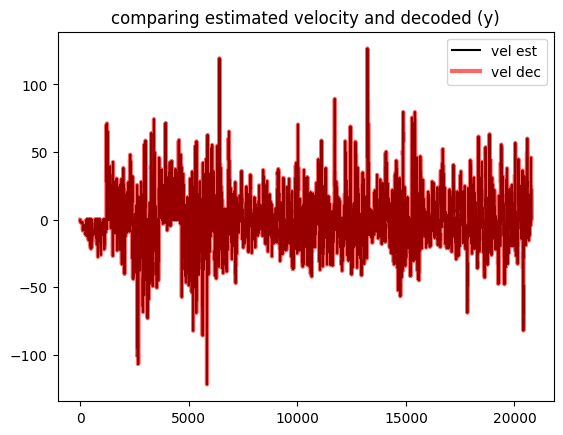

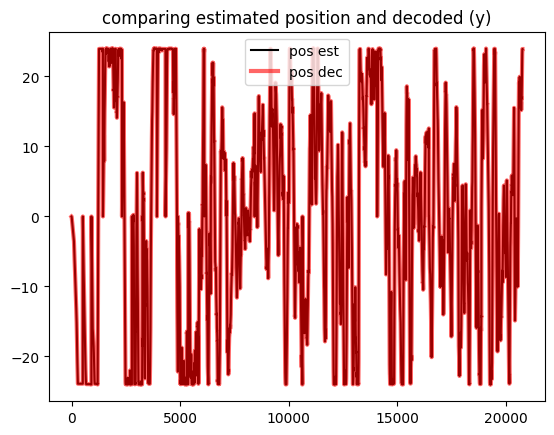

Text(0.5, 1.0, 'error in y-estimations')

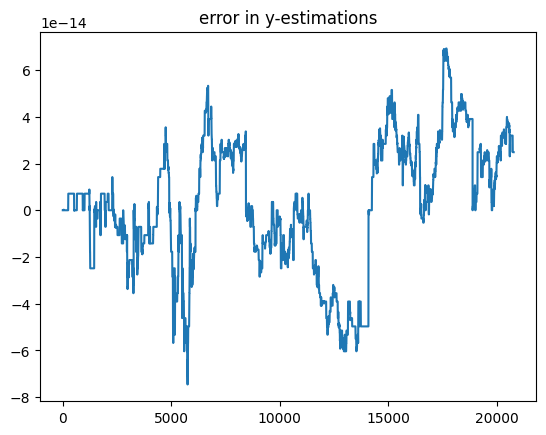

In [14]:
plt.plot(vel_est[:time_x, 1], '-', label = "vel est", color = 'black')
plt.plot(vel_dec[:time_x, 1], lw = 3, label = "vel dec", alpha = 0.6, color = 'red')
plt.legend()
plt.title("comparing estimated velocity and decoded (y)")
plt.show()

plt.plot(pos_est[:time_x, 1], '-', label = "pos est", color = 'black')
plt.plot(pos[:time_x, 1], lw = 3, label = "pos dec", alpha = 0.6, color = 'red')
plt.legend()
plt.title("comparing estimated position and decoded (y)")
plt.show()


plt.plot(pos_est[:time_x, 1] - pos[:time_x, 1])
plt.title("error in y-estimations")

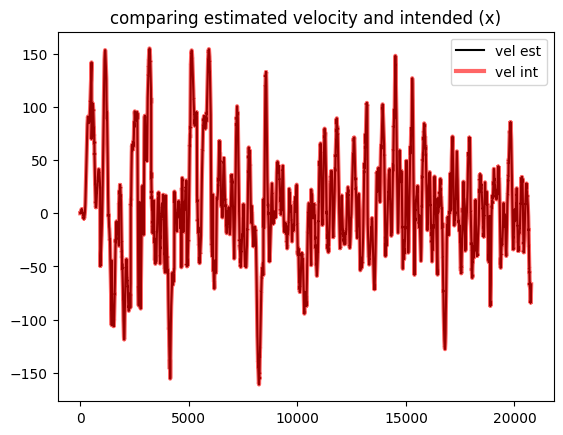

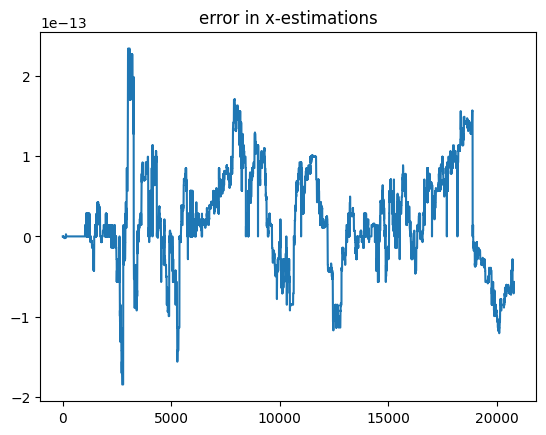

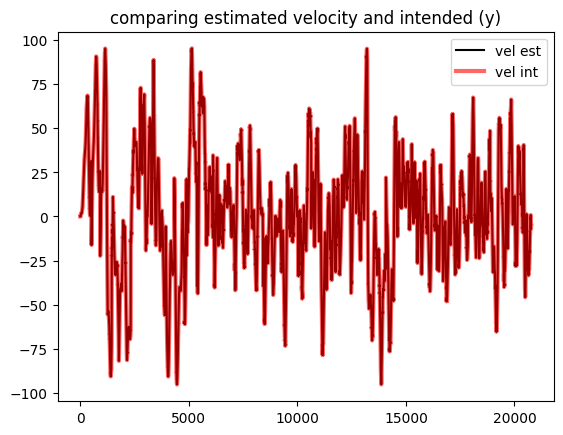

Text(0.5, 1.0, 'error in y-estimations')

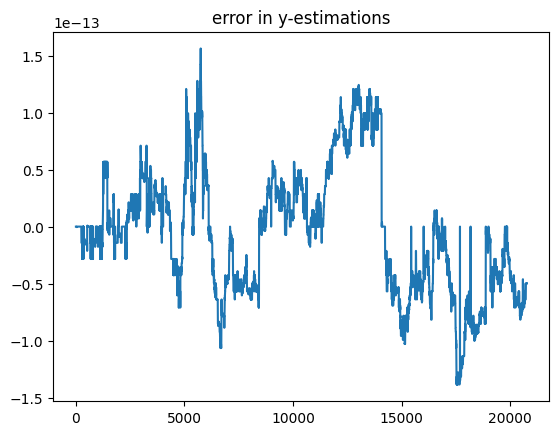

In [15]:
plt.plot(int_vel_est[:time_x, 0], '-', label = "vel est", color = 'black')
plt.plot(vel_int[:time_x, 0], lw = 3, label = "vel int", alpha = 0.6, color = 'red')
plt.legend()
plt.title("comparing estimated velocity and intended (x)")
plt.show()


plt.plot(int_vel_est[:time_x, 0] - vel_int[:time_x, 0])
plt.title("error in x-estimations")
plt.show()

plt.plot(int_vel_est[:time_x, 1], '-', label = "vel est", color = 'black')
plt.plot(vel_int[:time_x, 1], lw = 3, label = "vel int", alpha = 0.6, color = 'red')
plt.legend()
plt.title("comparing estimated velocity and intended (y)")
plt.show()


plt.plot(int_vel_est[:time_x, 1] - vel_int[:time_x, 1])
plt.title("error in y-estimations")

## fixed decoder

In [16]:
subj = keys[0]
c = 3
ref = refs_block1[subj][c, :]
pos = poss_block1[subj][c, :]
emg = emgs_block1[subj][c, :]
Ds = Ws_block1[subj][c, :]
vel_int = int_vel_block1[subj][c, :]
vel_dec = dec_vels_block1[subj][c, :]

# ref = refs_block2[subj][c, :]
# pos = poss_block2[subj][c, :]
# emg = emgs_block2[subj][c, :]
# Ds = Ws_block2[subj][c, :]
# vel_int = int_vel_block2[subj][c, :]
# vel_dec = dec_vels_block2[subj][c, :]

In [17]:
70*120

8400

In [18]:
Ds[-1].shape

(2, 64)

In [19]:
Dfix = Ds[-1]
time_x = n_time
(vel_fixed, pos_fixed, int_vel_fixed) = reconstruct_trial_fixed_decoder(ref, emg, Dfix, time_x, fs = 60)

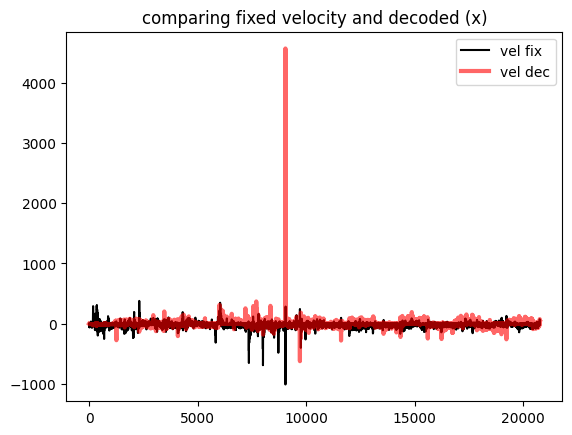

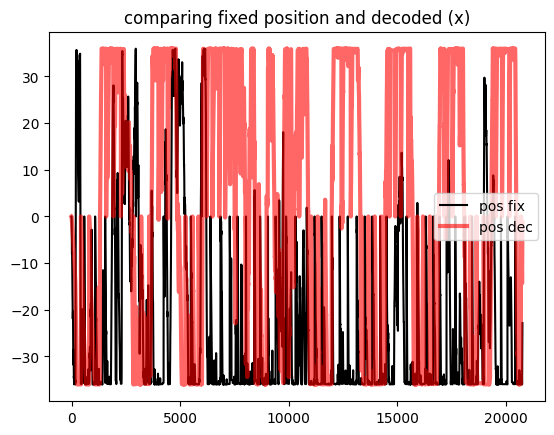

False

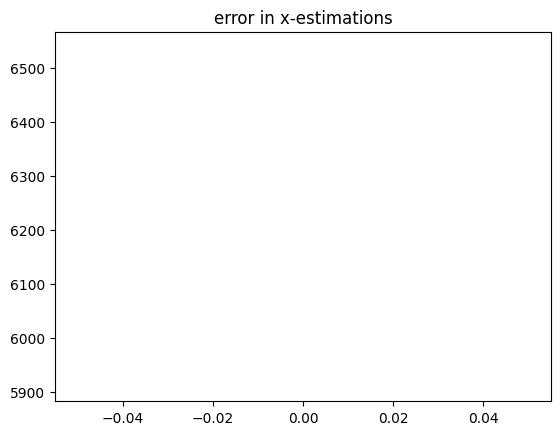

In [20]:
plt.plot(vel_fixed[:time_x, 0], '-', label = "vel fix", color = 'black')
plt.plot(vel_dec[:time_x, 0], lw = 3, label = "vel dec", alpha = 0.6, color = 'red')
plt.legend()
plt.title("comparing fixed velocity and decoded (x)")
plt.show()

plt.plot(pos_fixed[:time_x, 0], '-', label = "pos fix", color = 'black')
plt.plot(pos[:time_x, 0], lw = 3, label = "pos dec", alpha = 0.6, color = 'red')
plt.legend()
plt.title("comparing fixed position and decoded (x)")
plt.show()

plt.plot(np.linalg.norm(pos_fixed[:time_x, 0] - pos[:time_x, 0], axis=0))
plt.title("error in x-estimations")

np.allclose(pos_est[:time_x, 0] - pos[:time_x, 0], 0)

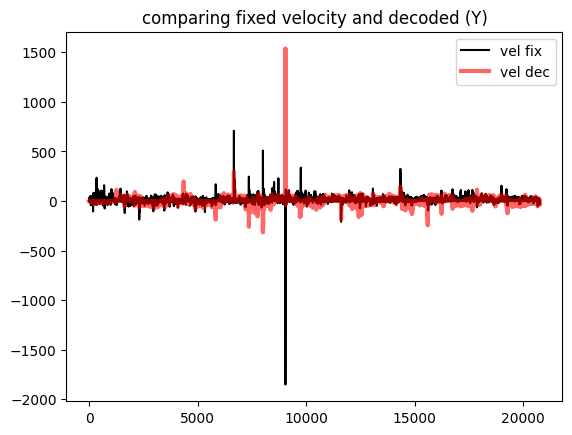

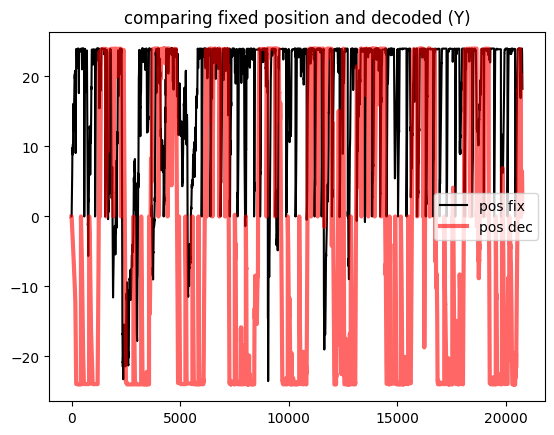

False

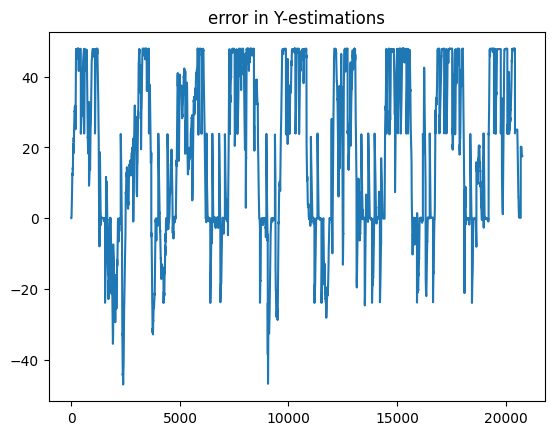

In [21]:
plt.plot(vel_fixed[:time_x, 1], '-', label = "vel fix", color = 'black')
plt.plot(vel_dec[:time_x, 1], lw = 3, label = "vel dec", alpha = 0.6, color = 'red')
plt.legend()
plt.title("comparing fixed velocity and decoded (Y)")
plt.show()

plt.plot(pos_fixed[:time_x, 1], '-', label = "pos fix", color = 'black')
plt.plot(pos[:time_x, 1], lw = 3, label = "pos dec", alpha = 0.6, color = 'red')
plt.legend()
plt.title("comparing fixed position and decoded (Y)")
plt.show()

plt.plot(pos_fixed[:time_x, 1] - pos[:time_x, 1])
plt.title("error in Y-estimations")

np.allclose(pos_est[:time_x, 1] - pos[:time_x, 1], 0)

Text(0, 0.5, 'norm')

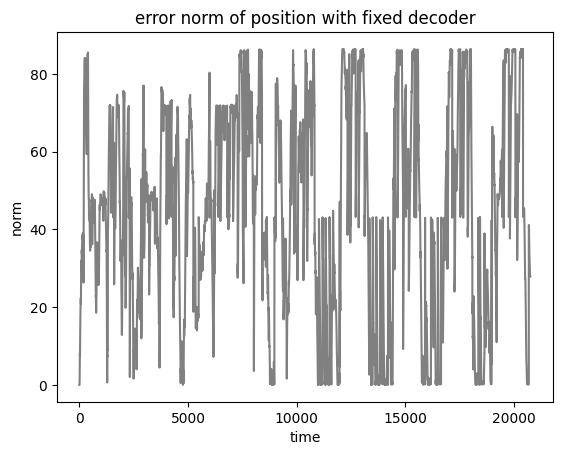

In [22]:
# error norm

plt.plot(np.linalg.norm(pos_fixed[:time_x, :] - pos[:time_x, :], axis = 1), color = 'gray')
plt.title("error norm of position with fixed decoder")
plt.xlabel("time")
plt.ylabel("norm")